# Introduction to Databricks Lakehouse

**Training Objective:** Understanding the Lakehouse architecture and Databricks platform capabilities.

**Topics Covered:**
- Lakehouse Architecture
- Unity Catalog
- Compute Options
- Delta Lake

## Theoretical Introduction

**Section Objective:** Understand the fundamental concepts of Lakehouse.

**Basic Concepts:**
- **Lakehouse**: Combines Data Lake (low cost, open formats) with Data Warehouse (reliability, SQL performance).
- **ACID Transactions**: Atomicity, Consistency, Isolation, Durability - guarantees data reliability.
- **Delta Lake**: Open-source storage layer ensuring transactionality on Parquet files.
- **Unity Catalog**: Unified governance for data and AI.

**Practical Application:**
- Elimination of data duplication between analytical and operational systems
- Simultaneous support for BI, Data Science, and Machine Learning
- Reduction of infrastructure and maintenance costs

## User Isolation

In [0]:
%run ../00_setup

## Environment Configuration

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
import re

# Display user context (variables from 00_setup)
print("=== User Context ===")
print(f"Catalog: {CATALOG}")
print(f"Schema Bronze: {BRONZE_SCHEMA}")
print(f"Schema Silver: {SILVER_SCHEMA}")
print(f"Schema Gold: {GOLD_SCHEMA}")
print(f"User: {raw_user}")

In [0]:
# Set catalog as default
spark.sql(f"USE CATALOG {CATALOG}")

## The Story & Context

### The Story: Why Are We Here?

You're a **Data Engineer at a growing e-commerce company**. The business has:
- **10,000+ customers** across multiple regions
- **50,000+ orders** per month, growing 30% YoY
- **500+ products** with complex pricing and inventory

**The Problem:**
- Data lives in CSV files, JSON APIs, and legacy databases
- Data Scientists wait 2 days to get clean data
- BI dashboards show data from yesterday (T-1 latency)
- Nobody knows which version of "customer data" is correct
- GDPR compliance is challenging - no audit trail

**Your Mission:**
Build a modern data platform that provides:
- Real-time data access (minutes, not days)
- Single source of truth (no more "which spreadsheet is correct?")
- Full audit trail and governance
- Self-service analytics for business users

**The Solution:** Databricks Lakehouse with Unity Catalog

### What You'll Learn (and Why It Matters)

| Topic | Why It Matters for You |
|-------|------------------------|
| Lakehouse Architecture | Understand trade-offs vs. traditional DW + Lake |
| Unity Catalog | Implement governance without slowing down |
| Compute Options | Choose right cluster type, control costs |
| Delta Lake | ACID transactions on files - ensures data integrity |

**Target Audience:** Experienced Data Engineers who want to understand *when* and *why* to use these tools, not just *how*.

## Lakehouse Architecture - The "Why"

### The Evolution of Data Architectures

**Generation 1: Data Warehouse (1990s-2000s)**
- Teradata, Oracle, SQL Server
- Structured data only, expensive storage
- Great for BI, less suitable for ML/unstructured data

**Generation 2: Data Lake (2010s)**
- Hadoop, S3, ADLS
- Cheap storage, any format
- Problem: "Data Swamp" - no governance, no ACID, unreliable

**Generation 3: Lakehouse (2020s)**
- Delta Lake, Iceberg, Hudi
- Best of both: cheap storage + ACID + governance
- Single platform for BI, ML, streaming

### Decision Framework: When to Use What?

| Scenario | Recommended Architecture | Why |
|----------|--------------------------|-----|
| Regulatory industry (banking, healthcare) | Lakehouse with strong governance | Audit trails, lineage, access control |
| ML-heavy workloads | Lakehouse | Native support for feature stores, MLflow |
| Legacy BI migration | Start with DW, migrate to Lakehouse | Lower risk, gradual transition |
| Startup with greenfield | Lakehouse from day 1 | Future-proof, lower TCO |
| Real-time + batch hybrid | Lakehouse with Delta | Unified streaming and batch |


### Alternatives to Databricks Lakehouse

| Alternative | Pros | Cons | When to Choose |
|-------------|------|------|----------------|
| **Snowflake** | Mature, great SQL | Separate from ML, vendor lock-in | Pure SQL/BI workloads |
| **BigQuery** | Serverless, cheap storage | GCP-only, less flexible | GCP shop, ad-hoc analytics |
| **Spark + Iceberg on K8s** | Open source, no vendor | Complex ops, no unified governance | Strong DevOps team, cost-sensitive |
| **Databricks** | Unified platform, strong ML/AI | Premium pricing | ML + Analytics + Streaming |

## Comparison of Traditional Architecture vs Lakehouse

**Objective:** Visualize differences between traditional approach (Data Lake + Data Warehouse) and Lakehouse.


![alt text](../../assets/images/g0on0aJG8cxp8DtvZSszq.png)

**Lakehouse Benefits:**
- Single copy of data (single source of truth)
- Lower storage costs
- Elimination of synchronization latency
- Common governance for all use cases

## Databricks Platform Elements

**Theoretical Introduction:**

The Databricks platform consists of several key components that together create a complete environment for working with data in the Lakehouse architecture.

**Key Components:**
- **Workspace**: Working environment containing notebooks, experiments, folders, and resources
- **Catalog Explorer**: Interface for managing catalogs, schemas, tables, and views
- **Git Folders (formerly Repos)**: Git integration for versioning notebooks and code
- **Volumes**: Management of unstructured files (images, models, artifacts)
- **DBFS (Databricks File System)**: Virtual file system over cloud storage

**Practical Application:**
- Workspace organizes projects and team collaboration
- Catalog Explorer enables data exploration and governance
- Git Folders integrates development workflow with Git

## Example: Workspace Exploration

**Objective:** Familiarize with Databricks Workspace interface

**Workspace Elements:**
1. **Sidebar** (left side):
   - Workspace: Folders and notebooks
   - Git Folders: Git Integration
   - Compute: Cluster management
   - Workflows: Databricks Jobs
   - Catalog: Unity Catalog explorer

2. **Main Panel**: Notebook editor or details view

## Example: Catalog Explorer - Unity Catalog Structure

**Objective:** Understand object hierarchy in Unity Catalog

In [0]:
# Display current catalog and schema
current_catalog = spark.sql("SELECT current_catalog()").collect()[0][0]
current_schema = spark.sql("SELECT current_schema()").collect()[0][0]

print(f"Current catalog: {current_catalog}")
print(f"Current schema: {current_schema}")

**Unity Catalog Hierarchy:**

![alt text](../../assets/images/_CLlYYph1poAK9zrFCPZL.png)

Unity Catalog organizes data in three levels: `catalog.schema.table`

**Explanation:**

Unity Catalog organizes data in hierarchy: Metastore → Catalog → Schema → Objects (Tables/Views/Functions). This structure enables:
- Logical separation of environments (dev/test/prod)
- Granular access control at each level
- Easy management of namespaces and project isolation

## Example: Browsing Catalogs and Schemas

**Objective:** Programmatic listing of objects in Unity Catalog

In [0]:
# List of all catalogs available to the user
catalogs_df = spark.sql("SHOW CATALOGS")
display(catalogs_df)

In [0]:
# List of schemas in the current catalog
schemas_df = spark.sql(f"SHOW SCHEMAS IN {CATALOG}")
display(schemas_df)

**Explanation:**

Commands `SHOW CATALOGS` and `SHOW SCHEMAS` allow exploring Unity Catalog structure. Each user sees only objects they have permissions for. Per-user isolation (as in our `00_setup`) ensures each training participant has their own workspace.

## Git Folders (Repos) and Git Integration

In practice, working with code in Databricks should be based on **Git Folders** (formerly Repos), not single, orphaned notebooks in Workspace.

Typical workflow:

1. **Create Git Folder** in Databricks: `Workspace → Git Folders → Add Repo`.
2. **Connect to Git** (GitHub / Azure DevOps / other).
3. Work on **feature branches** (e.g., `feature/cleaning-module`).
4. Regularly:
   - commit and push changes from Databricks to remote repo,
   - create PR and merge to main/dev.

Best Practices:

- One repo per project/domain (e.g., `databricks-dea-training`).
- Do not work in **Workspace root** – always in **Git Folders**.
- Training notebooks, test data, and README can be in one repo.

## Volumes vs DBFS – where to store files?

In new workspaces based on Unity Catalog, the preferred place for storing files are **Volumes**.

- `dbfs:/` is treated as a **legacy** layer or auxiliary area.
- `volume://catalog.schema.volume_name` is a fully managed, UC-controlled data area (permissions, audit, lineage).

Volume Definition Example (SQL):

```sql
CREATE VOLUME IF NOT EXISTS ${catalog}.${schema}.training_volume
COMMENT 'Workspace for training purposes';
```

Usage Example in PySpark:

```python
catalog = dbutils.widgets.get("catalog")
schema = dbutils.widgets.get("schema")

volume_path = f"volume://{catalog}.{schema}.training_volume"
display(dbutils.fs.ls(volume_path))
```

## Serverless SQL / SQL Warehouse – when to use instead of notebook cluster?

Besides notebook clusters, Databricks offers **SQL Warehouse (serverless)** – SQL query engine optimized for BI and ad-hoc analytics.

When to use:
- Reporting in Power BI / other BI tools.
- Business analysts / power users working mainly in SQL.
- Interactive dashboards and ad-hoc queries to **Gold** layer.

Differences from all-purpose cluster:
- Billing based on **DBU SQL** (different rates).
- Automatic provisioning / scaling.
- Isolation of BI workload from engineering clusters.

---

# Compute - Making Smart Choices

## The Real Question: How Much Will This Cost?

As a Data Engineer, you'll be asked: *"Why is our Databricks bill so high?"*

Understanding compute options is essential for cost control.

## Compute Options Comparison

| Type | Startup Time | Cost Model | Best For |
|------|--------------|------------|----------|
| **All-Purpose Cluster** | 3-5 min | Per-minute (running) | Interactive development, exploration |
| **Job Cluster** | 3-5 min | Per-minute (only during job) | Scheduled production jobs |
| **Serverless (Preview)** | <10 sec | Per-query DBUs | Ad-hoc queries, variable workloads |
| **SQL Warehouse** | 0 (Serverless) or 3-5 min | Per-query DBUs | BI tools, SQL analysts |

## Cost Optimization Strategies

**1. Right-size clusters:**
- Development: 2-4 workers, smallest instance type
- Production: Autoscaling 2-10 workers based on workload

**2. Use Spot/Preemptible instances:**
- 60-80% cost savings for workers
- Driver on on-demand (stability)
- Trade-off: Job may be interrupted

**3. Photon Engine:**
- 2-3x faster for aggregations/joins
- ~2x DBU cost, but finishes faster = often cheaper
- Enable for: large scans, aggregations, joins
- Skip for: simple transformations, ML training

**4. Cluster policies:**
- Enforce maximum worker count
- Require autoscaling
- Set auto-termination (e.g., 30 min idle)

## Decision Tree: Which Compute to Use?


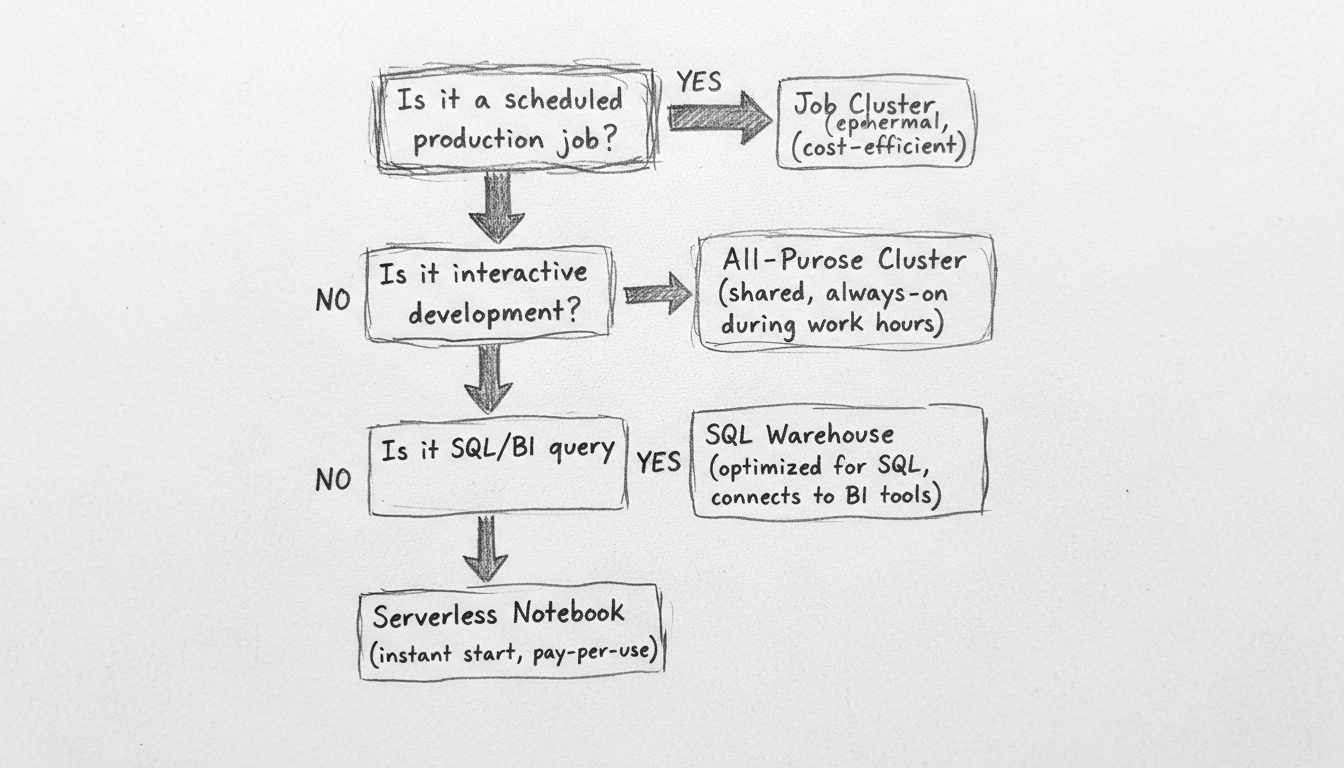](../../assets/images/_4pq8XonhnkHqJAjFWweG.png)



---

## Example: Cluster Information

**Objective:** Check current cluster configuration

In [0]:
# Runtime version
dbr_version = spark.conf.get("spark.databricks.clusterUsageTags.sparkVersion", "unknown")

In [0]:
print(dbr_version)

In [0]:
# Photon enabled?
photon_enabled = spark.conf.get("spark.databricks.photon.enabled", "false")

In [0]:
print(photon_enabled)

**Explanation:**

This code shows basic information about the Spark cluster. The number of executors (workers) can change dynamically with autoscaling enabled. Photon Engine, if enabled, automatically accelerates SQL queries and DataFrame operations without code changes.

# Magic Commands in Notebooks

## Theoretical Introduction

Databricks notebooks support magic commands - special commands starting with `%` that control the cell language or execute system operations. Magic commands allow mixing languages in a single notebook and interacting with the file system.

**Available magic commands:**
- **%python**: Python cell (default)
- **%sql**: SQL cell
- **%scala**: Scala cell
- **%r**: R cell
- **%md**: Markdown cell (documentation)
- **%fs**: File system operations (DBFS)
- **%sh**: Shell commands
- **%run**: Run another notebook (like import)
- **%pip**: Install Python libraries (notebook-scoped)
- **%skip**: Skips cell execution

**Practical Application:**
- Combining SQL and Python in one workflow
- Inline documentation with Markdown
- File operations with %fs
- Code modularization with %run
- Dependency management with %pip

## Monitoring and Logging – Where to Look for Problems?

When working with clusters and Jobs, it's worth knowing the basic places where we look for diagnostic information:

- **Cluster → Event log** – cluster start/stop, autoscaling, infrastructure errors.
- **Spark UI** (Jobs, SQL, Storage, Environment tabs) – execution plan, shuffling, task-level errors.
- **Driver / Executor logs** – detailed Python/Scala stacktraces.
- **Job Run page** – status of individual tasks, retries, execution time.

Best Practices:
- For longer pipelines, always check Spark UI (SQL/Jobs section).
- Log critical application logs to Delta tables / storage, not just cluster logs.

## Example: SQL Magic Command Demonstration

**Objective:** Execute SQL query directly in the notebook

In [0]:
%sql
-- SQL magic command allows writing pure SQL without Python wrapper

SELECT 
  current_catalog() as catalog,
  current_schema() as schema,
  current_user() as user,
  current_timestamp() as timestamp

**Explanation:**

The `%sql` magic command changes the cell language to SQL. Results are automatically displayed as a table. SQL in Databricks is full Spark SQL with Delta Lake extensions.

## Example: File System Operations with fs

**Objective:** Explore DBFS file system

In [0]:
# List root directories in DBFS
dbutils.fs.ls("/")

**Explanation:**

DBFS (Databricks File System) is an abstraction over cloud storage (S3, ADLS, GCS). The `%fs` command or `dbutils.fs` allows file operations. In Unity Catalog, it is recommended to use **Volumes** instead of DBFS for better governance.

## Example: Mixing Languages - Python and SQL

**Objective:** Demonstrate seamless transition between Python and SQL

In [0]:
# Python: Raw data definition
data = [
    (1, "Alice", "Engineering", 95000),
    (2, "Bob", "Sales", 75000),
    (3, "Charlie", "Engineering", 105000),
    (4, "Diana", "Marketing", 68000),
    (5, "Eve", "Engineering", 98000)
]

# Schema definition
schema = StructType([
    StructField("id", IntegerType(), False),
    StructField("name", StringType(), False),
    StructField("department", StringType(), False),
    StructField("salary", IntegerType(), False)
])

In [0]:
# Create DataFrame
df = spark.createDataFrame(data, schema)
display(df)

In [0]:
# Register as temp view for SQL access
df.createOrReplaceTempView("employees_temp")

**Temp view created: employees_temp**

Temp view allows access to DataFrame from SQL cells in the same notebook.

In [0]:
%sql
-- SQL: Aggregation on Python data

SELECT 
  department,
  COUNT(*) as employee_count,
  AVG(salary) as avg_salary,
  MAX(salary) as max_salary
FROM employees_temp
GROUP BY department
ORDER BY avg_salary DESC

**Explanation:**

This example shows the power of Databricks notebooks: data preparation in Python (convenient API, libraries), then analysis in SQL (declarative queries, clarity). Temp views are visible throughout the notebook regardless of cell language.

## Example: Library Management (%pip)

In Databricks, we can install notebook-scoped Python libraries using the `%pip` command. This is the recommended approach instead of global installation on the cluster.

In [0]:
# Install emoji library
%pip install emoji

In [0]:
import emoji
print(emoji.emojize('Hello World :earth_africa:'))

## Databricks Assistant (AI)

In 2025, coding work is assisted by AI. Databricks has a built-in assistant (**Databricks Assistant**) that is context-aware of your data (knows table schemas in Unity Catalog!).

**How to use?**
1. Shortcut **Cmd+I** (Mac) or **Ctrl+I** (Windows) inside a cell.
2. "Assistant" side panel.

**What is it for?**
- **Code Generation**: "Write a SQL query that calculates average sales by region from the sales table".
- **Code Explanation**: Select a complex snippet and ask "Explain this code".
- **Fixing errors**: When a cell returns an error, click "Diagnose Error" – the assistant will explain the cause and propose a fix.
- **Transformation**: "Rewrite this code from PySpark to SQL".

---

# Unity Catalog vs Hive Metastore

## Theoretical Introduction

Databricks supports two metadata systems: legacy Hive Metastore and modern Unity Catalog. Unity Catalog is recommended for all new projects due to advanced governance and security features.

**Key Differences:**

| Aspect | Hive Metastore | Unity Catalog |
|--------|----------------|---------------|
| **Governance** | Limited | Full: RBAC, masking, audit |
| **Namespace** | 2-level (db.table) | 3-level (catalog.schema.table) |
| **Cross-workspace** | No | Yes (shared metastore) |
| **Lineage** | None | End-to-end lineage |
| **Data Sharing** | Limited | Delta Sharing protocol |
| **Isolation** | Workspace-level | Catalog-level |

**Why Unity Catalog?**
- Central access management for all workspaces
- Automatic lineage for audit and compliance
- Fine-grained permissions (column-level, row-level)
- Integration with external systems (Delta Sharing)

## Example: Namespace - Hive vs Unity Catalog

**Objective:** Compare table access syntax

**Hive Metastore (legacy)**

- **Syntax**: `database.table`
- **Example**: `default.sales_data`
- **Limitations**: No fine-grained permissions, no lineage, workspace isolation

**Unity Catalog (modern)**

- **Syntax**: `catalog.schema.table`
- **Example**: `prod.gold.sales_summary`

**3-level Namespace Advantages:**
- Environment separation (dev/test/prod catalogs)
- Better permissions (grant at catalog level)
- Metastore sharing between workspaces
- End-to-end lineage
- Fine-grained access control

## Example: Creating a Table in Unity Catalog

**Objective:** Demonstrate full syntax with 3-level namespace

In [0]:
# Create sample table in Unity Catalog
table_name = f"{CATALOG}.{BRONZE_SCHEMA}.lakehouse_demo"

# Demo data
demo_data = [
    (1, "Unity Catalog", "Enabled", "2024-01-15"),
    (2, "Delta Lake", "Enabled", "2024-01-15"),
    (3, "Photon Engine", "Enabled", "2024-01-15"),
    (4, "Hive Metastore", "Legacy", "2024-01-15")
]

In [0]:
# Schema definition
demo_schema = StructType([
    StructField("id", IntegerType(), False),
    StructField("feature", StringType(), False),
    StructField("status", StringType(), False),
    StructField("date", StringType(), False)
])

In [0]:
# Create DataFrame
demo_df = spark.createDataFrame(demo_data, demo_schema)
display(demo_df)

In [0]:
# Save as Delta Table in Unity Catalog
demo_df.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable(table_name)

In [0]:
# Verification
display(spark.table(table_name))

**Success!** The table has been created in Unity Catalog. We can now verify its existence.

### Task: Check in UI

1. Click **Catalog** in the left sidebar.
2. Find your catalog (name in `CATALOG` variable, e.g., `ecommerce_platform_...`).
3. Expand the `bronze` schema (or other defined in `BRONZE_SCHEMA`).
4. Click on the `lakehouse_demo` table.
5. See tabs: **Sample Data** (preview) and **Lineage** (data origin).

**Explanation:**

The table was created with a full 3-level namespace. In Unity Catalog, every table automatically:
- Is managed by the governance system
- Has tracked lineage
- Has permissions assigned based on catalog and schema
- Is available in Catalog Explorer for exploration

**Managed vs External Tables:**
The table above is a **Managed Table**. Databricks manages both metadata and data files (in default catalog/schema storage). Dropping the table (`DROP TABLE`) also deletes the data.

**External Table** is created when we provide `LOCATION 'path'`. Then `DROP TABLE` removes only metadata, and files remain in storage.

## Comparison PySpark vs SQL

**DataFrame API (PySpark):**

In [0]:
# PySpark Approach - programmatic DataFrame API

df_pyspark = spark.table(f"{CATALOG}.{BRONZE_SCHEMA}.lakehouse_demo")

In [0]:
result_pyspark = df_pyspark \
    .filter(F.col("status") == "Enabled") \
    .select("feature", "status", "date") \
    .orderBy("feature")

In [0]:
display(result_pyspark)

**SQL Equivalent:**

In [0]:
print(f"{CATALOG}.{BRONZE_SCHEMA}")

In [0]:
%sql

select * from 
ecommerce_platform_trainer.bronze.lakehouse_demo

### Parameterization with Databricks Widgets

Below we use the **Widgets** mechanism, which allows creating interactive controls in the notebook. This allows passing parameters (e.g., table names, dates) to SQL and Python code, facilitating the building of universal reports.

In [0]:
# Parameterization with Databricks Widgets
# Set default values based on variables from 00_setup (if available)
# This ensures SQL cells will use the same catalog as Python cells

default_catalog = CATALOG if 'CATALOG' in locals() else "ecommerce_platform_trainer"
default_schema = BRONZE_SCHEMA if 'BRONZE_SCHEMA' in locals() else "bronze"

dbutils.widgets.text("CATALOG", default_catalog)
dbutils.widgets.text("BRONZE_SCHEMA", default_schema)

In [0]:
%sql

SELECT 
  feature,
  status,
  date
FROM IDENTIFIER(:CATALOG || '.' || :BRONZE_SCHEMA || '.lakehouse_demo')
WHERE status = 'Enabled'
ORDER BY feature

**Comparison:**
- **Performance**: Identical - both approaches compile to the same Catalyst query plan
- **When to use PySpark**: 
  - Complex business logic with UDFs
  - Dynamic pipelines (parameterization, loops)
  - Integration with Python libraries (pandas, scikit-learn)
- **When to use SQL**: 
  - Simple transformations and aggregations
  - Team with strong SQL skills
  - Migration from traditional Data Warehouse
  - Better support for business analysts

## Summary

1. Learned Lakehouse concept as evolution of Data Lake + Data Warehouse
2. Explored Databricks platform elements: Workspace, Compute, Catalog
3. Understood Unity Catalog hierarchy: Metastore → Catalog → Schema → Objects
4. Practiced magic commands: %sql, %python, %fs, %pip
5. Compared Hive Metastore vs Unity Catalog
6. Created first Delta table in Unity Catalog with 3-level namespace

### Key Takeaways:
- **Lakehouse eliminates data duplication**: Single copy serves BI, ML, and real-time analytics
- **Unity Catalog is governance foundation**: 3-level namespace, fine-grained permissions, automatic lineage
- **Clusters are flexible**: Autoscaling and spot instances reduce costs, Photon accelerates queries
- **Notebooks are powerful**: Mixing SQL/Python, magic commands, Git integration via Git Folders
- **Delta Lake is default format**: ACID transactions, time travel, schema evolution

## Clean up resources

In [0]:
# spark.sql(f"DROP TABLE IF EXISTS ...")
display(spark.createDataFrame([("Status", "Resources kept for further exercises")], ["Info", "Value"]))